# ANLP Assignment: Sentiment Classification


In [1]:
candidateno=277178

In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /Users/sharmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sharmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sharmin/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['look', 'back', 'at', 'all', 'the', 'times', 'in', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [5]:
#for removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

#function for normalizing wordlists
def normalise(wordlist):
    lowered=[word.lower() for word in wordlist]
    filtered=[word for word in lowered if word.isalpha() and word not in stop]
    return filtered

#training and testing data of normalization
training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data] # training data of normalization
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data] # testing data of normlization

#initialization of empty frequency distribution for positive and negative words
pos_freq_dist=FreqDist() 
neg_freq_dist=FreqDist() 

for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist

posdiff = pos_freq_dist - neg_freq_dist
negdiff = neg_freq_dist - pos_freq_dist

#function for identifying most common words
def most_frequent_words(posfreq,negfreq,topk):
    difference=posfreq-negfreq
    sorteddiff=difference.most_common()
    justwords=[word for (word,freq) in sorteddiff[:topk]]
    return justwords

### 1. a

In [6]:
#identifying top 10 most common positive words
top_pos_words =most_frequent_words(pos_freq_dist,neg_freq_dist,10) 
print(top_pos_words)

['film', 'life', 'well', 'also', 'best', 'great', 'one', 'story', 'world', 'many']


### 1. b

In [7]:
#identifying top 10 most common negative words
top_neg_words = most_frequent_words(neg_freq_dist,pos_freq_dist,10)
print(top_neg_words)

['bad', 'movie', 'plot', 'worst', 'nothing', 'script', 'big', 'stupid', 'action', 'boring']


### 1. c

Here, I have imported `stopwords` nltk.corpus module which removes common words in the English language text such as ‘the’, ‘of’, ‘is’ etc. A `normalise` function has been created which performs a further preprocessing task, converting each word to the lowered case, filtering out any non-alphabetic character using the `is alpha ()` method, and removing stopwords from the wordlists. This normalization has been applied in both training and testing datasets. After that I have wanted to know how often the positive and negative wordlists occur in the wordlists. `FreqDist` from nltk.probability module is used to transform the wordlists into frequency distributions.

Here `training_norm` and `testing_norm` are two tuples that contain the frequency distribution of the wordlist and label of positive and negative. 

After that, an iteration through each word has been carried out and  I have initialized `pos_freq_dist` and the `neg_freq_dist` for normalized positive and negative frequency distribution. 

Here `posdiff` and `negdiff` are calculating the differences between positive and negative frequency distribution. 

`Most_frequent_words` is implemented to find out the top 10 most frequent positive and negative words that occur in the wordlist based on the difference between the frequency distribution. Finally, I’m printing `top_pos_words` which stores the top 10 most frequent positive words that occur in the wordlist, and printing `top_neg_words` which stores the top 10 most frequent negative words that occur in the wordlist.

2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


### 2. a

In [8]:
#initializing classifier
from nltk.classify.api import ClassifierI
import random

class SimpleClassifier(ClassifierI):
    def __init__(self, pos, neg):
        self._pos = pos
        self._neg = neg

    def classify(self, doc):
        #doc is a FreqDist
        score = 0
        #calculating frequency score of positive and negative
        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value

        return "neg" if score < 0 else "pos"
    #creating a tuple with label
    def labels(self):
        return ("pos", "neg")
    
#creating instance of SimpleClassifier
WordListClassifier = SimpleClassifier(top_pos_words, top_neg_words)

In [9]:
#testing classifier for positive review
WordListClassifier.classify(FreqDist("This song is great".split()))

'pos'

In [10]:
#testing classifier for negative review
WordListClassifier.classify(FreqDist("This song is boring".split()))

'neg'

### 2. b

Here I have initialized `SimpleClassifier`, an instance of a classifier object which has a classifying method that returns "pos" or "neg" which is called from nltk.classify.api module.

* Using the `init` method, positive and negative word lists have been stored in instance variables `self._pos` and `self._neg`
* The `classify` method takes taking freq distribution document and loops through each word, it increments for positive words and decrements for positive words and returns the 'neg' or 'neg' checking score value.
* `labels` method is labeling the word as 'pos' for positive words and 'neg' for negative words and creating a tuple.

After that, I created an instance of the `SimpleClassifier` which is `WordListClassifier`. To test the classifier I have tested with the sample document and it gives results accurately.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

### 3. a

In [11]:
#creating function for evaluating classifier
def classifier_evaluate(cls, test_data):
    acc = 0
    docs,goldstandard=zip(*test_data)
    predictions=cls.classify_many(docs) #classsifying document
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1
    return acc / (len(test_data))

docs,goldstandard = zip(*testing_norm) # seperating the frequency distribution and the label
predictions = WordListClassifier.classify_many(docs) # creating instance of the classifier
accuracy_1 = classifier_evaluate(WordListClassifier, testing_norm)

In [12]:
#defining confusion matrix
class ConfusionMatrix: 
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        
        #calculating total number of true positives, true negatives, false positives and false Negatives
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1

            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
                
    #function for precision calculation
    def precision(self):
        p=0

        p = self.TP / (self.TP + self.FP)

        return p

    #function for recall calculation
    def recall(self):
        r=0

        r = self.TP/(self.TP + self.FN)

        return r
    
    #function for f1 score calculation
    def f1(self):
        f1=0

        f1= 2*self.precision()*self.recall()/(self.precision()+self.recall())
        return f1
    
#initialization of confusion matris instance
ConfusionMatrix_1 = ConfusionMatrix(predictions,goldstandard) 
precision_1 = ConfusionMatrix_1.precision() #calculating precision
recall_1= ConfusionMatrix_1.recall() #calculating recall
f1_1= ConfusionMatrix_1.f1() #calculating f1

print('The accuracy of the WordList classifier is:', accuracy_1)
print('The Precision of the WordList classifier is', precision_1)
print( 'The recall of the WordList classifier is', recall_1)
print('The f1 of the WordList classifier is:', f1_1)

The accuracy of the WordList classifier is: 0.5966666666666667
The Precision of the WordList classifier is 0.5594262295081968
The recall of the WordList classifier is 0.91
The f1 of the WordList classifier is: 0.6928934010152284


### 3. b

Accuracy is not appropriate for evaluating a classifier if the data is imbalanced. Accuracy would be biased when calculating it in terms of imbalanced data. For example, if the training data has a wordlist of 90 positive words and 10 negative words. The accuracy for this classifier would be 90%. Because the dataset is imbalanced. It predicts well for the large number of positive words as the training dataset has a higher number of positive words and ignores truly negative words.

However, if the training dataset has a balanced dataset, such as it has 50 positive and 50 negative word reviews, it will achieve higher accuracy because of the balanced data.

Moreover, it's best to consider other metrics for evaluating classifier performance, such as precision, recall, and f1 score which provide better understanding of performance of a classifier.

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

### 4. a

In [13]:
#implementing Naive Bayes Classifier

from nltk.classify import NaiveBayesClassifier

#training naive bayes classifier
nltk_nb = NaiveBayesClassifier.train(training_norm)
nltk_nb_predictions =nltk_nb.classify_many(docs)

#initialization of confusion matris instance
ConfusionMatrix_2 = ConfusionMatrix(nltk_nb_predictions,goldstandard) 
precision_2 =ConfusionMatrix_2.precision() #calculating precision
recall_2 = ConfusionMatrix_2.recall() #calculating recall
f1_2 =ConfusionMatrix_2.f1() #calculating f1 score

print("The precision of the Naive Bayes classifier is:", precision_2)
print("The recall of the Naive Bayes classifier is:", recall_2)
print("The f1-score of the Naive Bayes classifier is:", f1_2)

The precision of the Naive Bayes classifier is: 0.6447368421052632
The recall of the Naive Bayes classifier is: 0.98
The f1-score of the Naive Bayes classifier is: 0.7777777777777777


### 4. b

In [14]:
#creating pandas dataframe with precision, recall, f1 of wordlist and naive bayes classifier
data = {'Wordlist_Classifier':[precision_1,recall_1,f1_1],'NaiveBayes_Classifier':[precision_2,recall_2,f1_2] } 
df_results = pd.DataFrame(data, index = ['precision','recall','f1']) # creating pandas dataframe with results
df_results

,Wordlist_Classifier,NaiveBayes_Classifier
precision,0.559426,0.644737
recall,0.910000,0.980000
f1,0.692893,0.777778


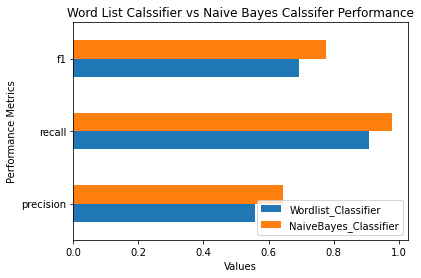

In [15]:
#plotting the evalution metrics into bar chart
df_results.plot.barh()

#adding title and labels
plt.title('Word List Calssifier vs Naive Bayes Calssifer Performance')
plt.xlabel('Values')
plt.ylabel('Performance Metrics')
plt.legend()
plt.show()

For comparing performance between Naive Bayes Classifer and WordList Classifier, I've created a dataframe where I've stored all the results such as Precision, Recall, and F1 score in `df_results` dataframe. 

After that I used bar plot using Matplotlib for visualising the comparison findings. From the bar plot I can see Naive Bayes Classifier outperforms than Wordlist Classifier in terms of precision, recall, and f1 score. 

* The `recall` of the Naive Bayes Classifier has the highest value of the evaluation metric at 0.98, while the recall of the Wordlist Classifier is 0.91.

* `Precision` of Naive Bayes Classifier is 0.64 and wordlist classifier is 0.56. Here Naive Bayes Classifier performs better than the wordlist classifier in terms of precision. In this case, the Naive Bayes Classifier outperforms the Wordlist Classifier in terms of precision.

* `F1 - score` for Naive Bayes Classifier is 0.78 and wordlist classifier 0.69. Here Naive Bayes Classifier performs better than wordlist classifier in terms of f1-score.

Moreover, Naive Bayes performs better for all the evaluation metrics in terms of recall, precision, and f1 score and works better as a classifier than a wordlist classifier.


5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


### 5 a

I have taken 80 instances of positive and negative word lists to experiment on the effect of the length of word lists. 
For the experiment, I've initialized empty accuracy, precision, recall, and f1 score lists which are `accuracy_list`, `precision_list`, `recall_list`, and `f1_list`, and have appended the evaluation metrics results in these lists. I've built it such that the most common words, which are higher frequency words in the wordlists, are chosen first, and the less common words appear later.

Here, The loop carries out the iteration from range 20 to 101 and creates `pos_review_wordlist` and `neg_review_wordlist` for each word from higher frequency positive and negative word distributions. Here, using the SimpleClassifier class, classify function, and confusion matrix instance, I have calculated and evaluated metrics such as accuracy, precision, recall, and F1 score have been calculated for each of the word lists.

In [16]:
#initializing empty lists to store metrics value
accuracy_list = []
precision_list =[]
recall_list = []
f1_list = []

for i in range(20,101):
  pos_review_wordlist =[i[0] for i in posdiff.most_common(i)]
  neg_review_wordlist =[i[0] for i in negdiff.most_common(i)]
  #initiazation of Classifier
  classifier2 = SimpleClassifier(pos_review_wordlist,neg_review_wordlist)
  predictions1 = classifier2.classify_many(docs)
  accuracy_list.append(classifier_evaluate(classifier2,testing_norm)) #calculating accuracy
  #initialization of confusion matris instance
  ConfusionMatrix_3 = ConfusionMatrix(predictions1,goldstandard)
  precision_list.append(ConfusionMatrix_3.precision()) #calculating precision
  recall_list.append(ConfusionMatrix_3.recall()) #calculating recall
  f1_list.append(ConfusionMatrix_3.f1()) #calculating f1 score

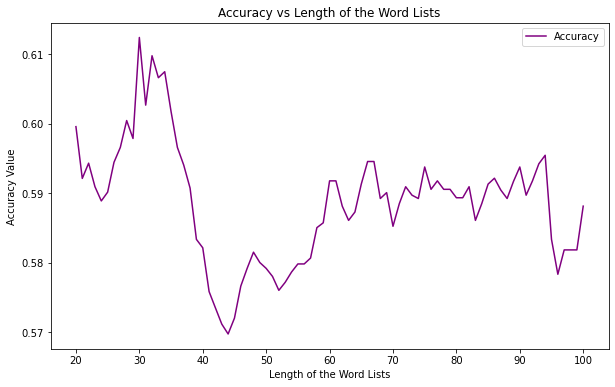

In [17]:
#setting range of the wordlists for plot
wordlist_len = list(range(20,101))

#accuracy vs Length of the Word Lists plot

#setting figure size
fig, ax = plt.subplots(figsize=(10, 6))

#plotting the results
plt.plot(wordlist_len, precision_list, 'purple', label = 'Accuracy')
#adding title and labels
plt.title('Accuracy vs Length of the Word Lists')
plt.xlabel('Length of the Word Lists')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

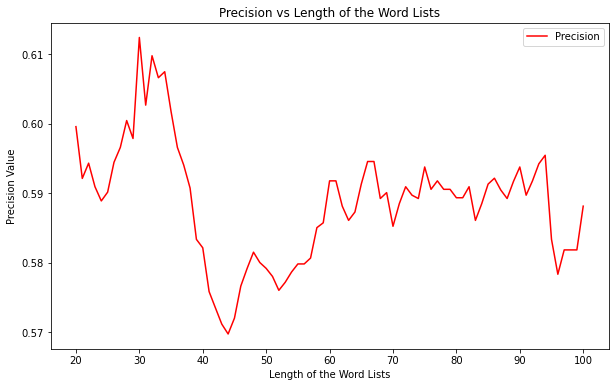

In [18]:
#Precision vs Length of the Word Lists plot

#setting figure size
fig, ax = plt.subplots(figsize=(10, 6))

#plotting the results
plt.plot(wordlist_len, precision_list, 'r', label = 'Precision')
#adding title and labels
plt.title('Precision vs Length of the Word Lists')
plt.xlabel('Length of the Word Lists')
plt.ylabel('Precision Value')
plt.legend()
plt.show()

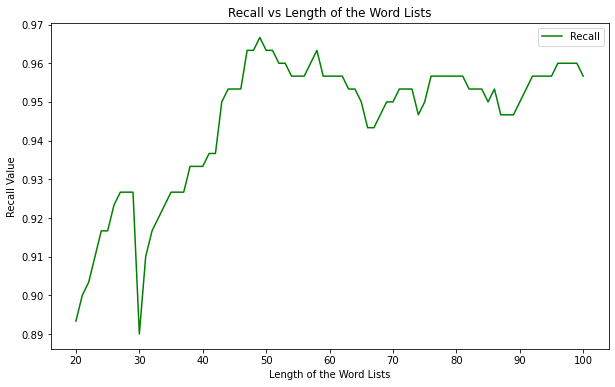

In [19]:
#Recall vs Length of the Word Lists plot

#setting figure size
fig, ax = plt.subplots(figsize=(10, 6))
#plotting the results
plt.plot(wordlist_len, recall_list, 'g', label = 'Recall')
#adding title and labels
plt.title('Recall vs Length of the Word Lists')
plt.xlabel('Length of the Word Lists')
plt.ylabel('Recall Value')
plt.legend()
plt.show()

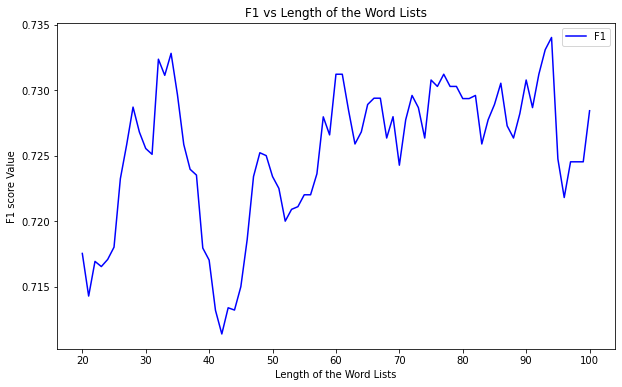

In [20]:
#F1 vs Length of the Word Lists plot

#setting figure size
fig, ax = plt.subplots(figsize=(10, 6))
#plotting the results
plt.plot(wordlist_len, f1_list, 'b', label = 'F1')
#adding title and labels
plt.title('F1 vs Length of the Word Lists')
plt.xlabel('Length of the Word Lists')
plt.ylabel('F1 score Value')
plt.legend()
plt.show()

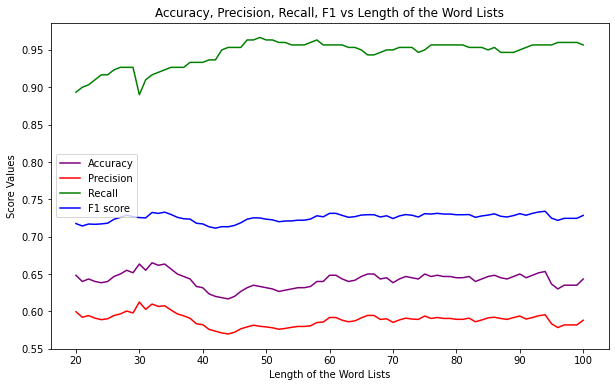

In [21]:
#Accuracy, Precision, Recall , F1 vs Length of the Word Lists plot

#setting figure size
fig, ax = plt.subplots(figsize=(10, 6))
#plotting the results
plt.plot(wordlist_len, accuracy_list, 'purple', label = 'Accuracy')
plt.plot(wordlist_len, precision_list, 'r', label = 'Precision')
plt.plot(wordlist_len,recall_list, 'g', label = 'Recall')
plt.plot(wordlist_len, f1_list, 'b', label = 'F1 score')
#adding title and labels
plt.title('Accuracy, Precision, Recall, F1 vs Length of the Word Lists')
plt.xlabel('Length of the Word Lists')
plt.ylabel('Score Values')
plt.legend()
plt.show()

I've used line graph for visualizing comparison using matplotlib and plotted accuracy, precision, recall and F1 score vs length of the wordlist. Here it is observered that as the length of the wordlists increases, the precision, recall, and F1 score maintains a steady flactuating flow in a non-linear fashion.

* Considering `accuracy`, the peak value is above 0.61 when the length is 30, and after that, it decreases and becomes 0.57. From the above 40 wordlists length, the accuracy value having non-linear flow.

* For `precision` at the beginning it has increasing flow but there is a drastic drop of the recall value when the length is larger than 30 and the value becomes 0.57. After that, it again increases to 0.58 between 50 to 60 wordlength. 

* Regarding `recall` we are seeing a drop when 30 wordlists and the value becomes 0.92 to 0.89. after that recall value has an increasing flow between 30 and 50 word length and the highest recall is approximately 0.96 in that range. After that it decreases the value and becomes steady.

* For `f1`, it decreases from 0.73 to 0.71 when word length is around 40. After that, it increases and flactuates between 50 to 100 word length.

###  5 b

I would prefer to use the Naive Bayes classifier to work on future work in this area.

While the Wordlist classifier may work better in simpler and smaller datasets, it has some drawbacks. As it depends on the fixed set of predefined lists of words, that's why when the dataset becomes larger it cannot classify new words. That's how it limits its effectiveness as a classifier. 

On the other hand, Naive Bayes considers the frequency distribution of words and can predict to classify data which makes it a more robust classifier when working with larger datasets and can able to predict and classify word accurately in terms of large datasets offering optimal performance.

Therefore, I will recommend using Naive Bayes because of its ability to classify large data models.
